In [13]:
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np

In [14]:
columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']
df = pd.read_excel('Вхідні дані.xlsx', header = None, skiprows = 1, names = columns)
df.index = df["Date"]
df.index = pd.to_datetime(df.index)
df.head()

,Date,Open,High,Low,Close,Volume
Date,,,,,,
2024-07-05,2024-07-05,1194.15,1194.15,1194.15,1194.15,NaN
2024-07-04,2024-07-04,1194.15,1194.15,1194.15,1194.15,NaN
2024-07-03,2024-07-03,1194.15,1194.15,1194.15,1194.15,NaN
2024-07-02,2024-07-02,1194.15,1194.15,1194.15,1194.15,NaN
2024-07-01,2024-07-01,1194.15,1194.15,1194.15,1194.15,6240.0


### **Історичні значення індексу UX (з 20-02-2020 по 23-02-2022)**

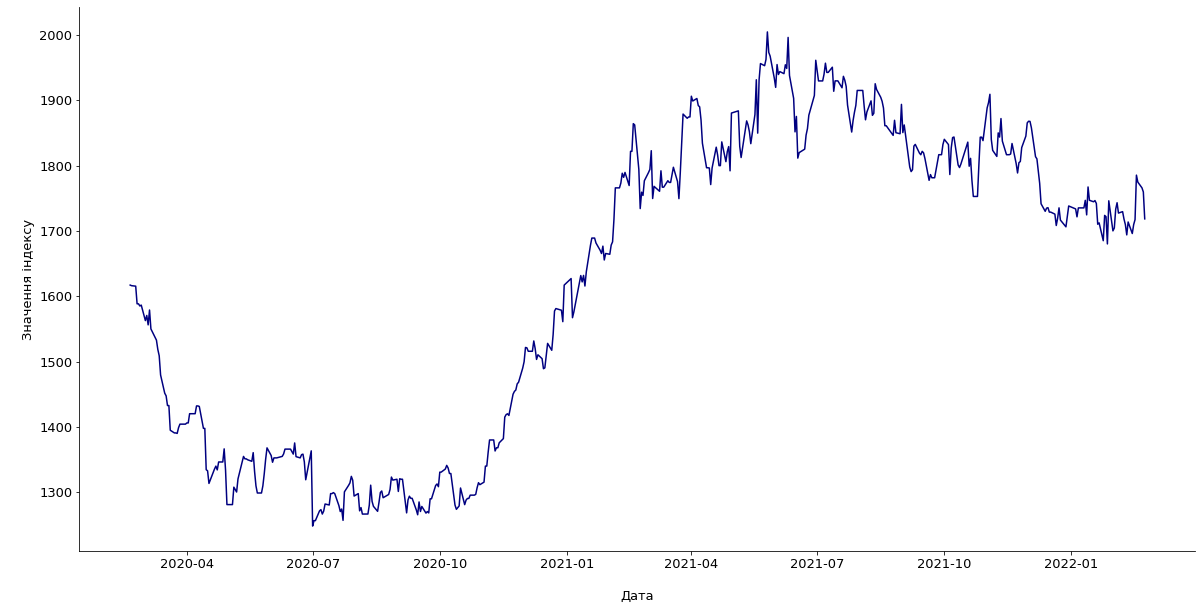

In [15]:
start_date = pd.to_datetime('2020-2-20')
end_date = pd.to_datetime('2022-2-23')
plt.rcParams.update({'font.size': 13})
df1 = df.loc[(df['Date']>=start_date) & (df['Date']<=end_date)]
stock_data = df1.set_index('Date')
plt.figure(figsize=(20,10))
ax = plt.axes()
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
plt.xlabel('\nДата')
plt.ylabel('\nЗначення індексу')
plt.plot(stock_data.index, stock_data["Close"], color='navy', linewidth=1.5)

### **Динаміка сумарного обєму торгів за день**

Text(0, 0.5, "\nОб'єм торгів")

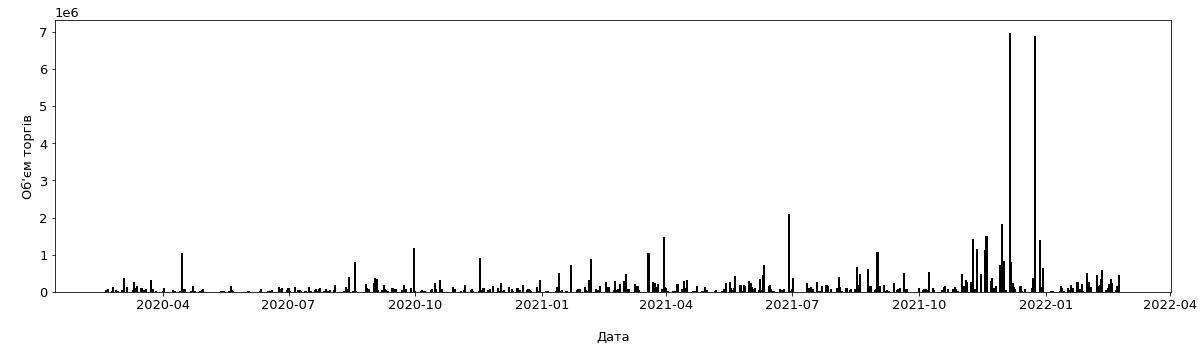

In [16]:
plt.rcParams.update({'font.size': 13})
plt.figure(figsize=(20,5))
plt.bar(stock_data.index, stock_data['Volume'],color='black',width=1.5)
plt.xlabel('\nДата')
plt.ylabel('\nОб\'єм торгів')

### **Пропущені значення**

<AxesSubplot:>

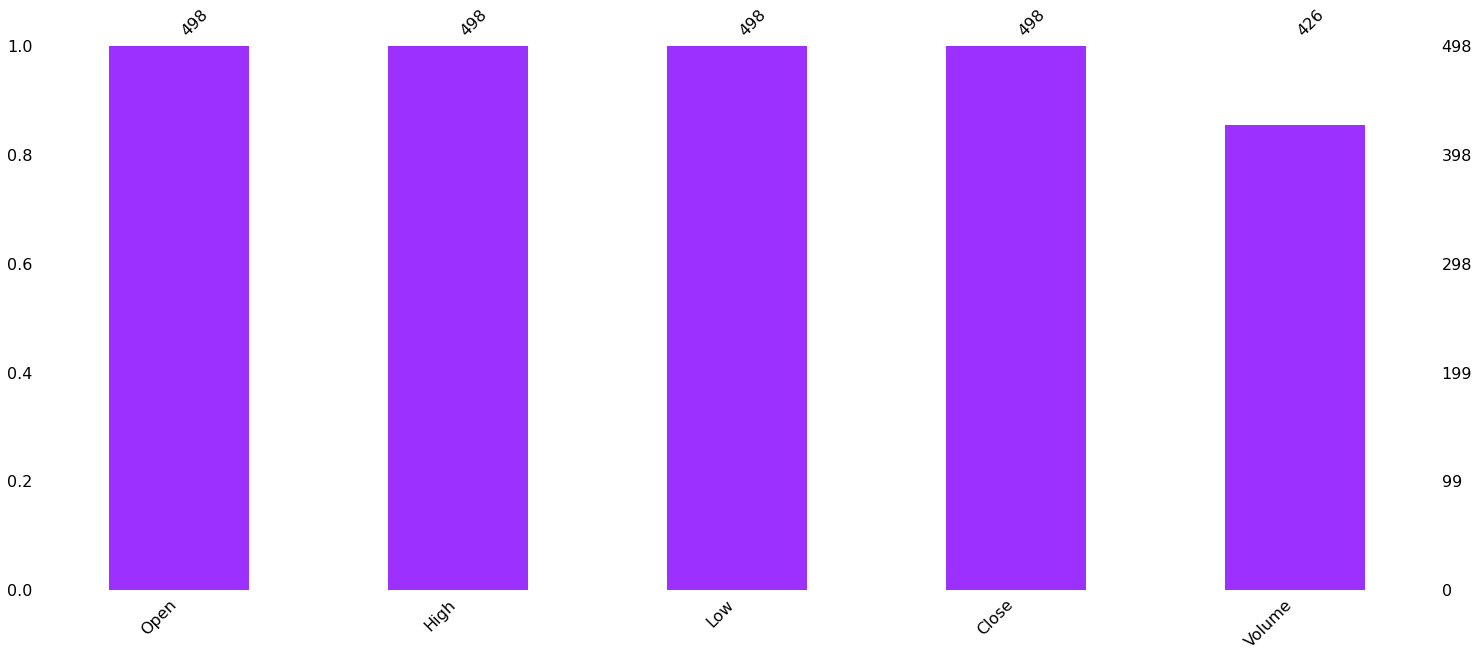

In [17]:
msno.bar(stock_data, color = (138/225,43/225,225/225))

### **SMA**

In [18]:
def SMA(data,n):

  #додаємо NaN на початку
	sma_list=[np.nan for k in range(n-1)]

	for i in range(len(data)-n+1):
		sum_n = 0
		for j in range(n):
			sum_n = sum_n + data[i+j]
		sma=sum_n/n
		sma_list.append(round(sma, 2))

	return sma_list

### **LWMA**

In [19]:
def LWMA(data,n):

	lma_list=[np.nan for k in range(n-1)]

	for i in range(len(data)-n+1):
		sum_n, sum_j = 0, 0
		for j in range(n):
			sum_n = sum_n + (j+1)*data[i+j]
			sum_j = sum_j + (j+1)
		lma=sum_n/sum_j
		lma_list.append(lma)

	return lma_list

### **EMA**

In [20]:
def EMA(data, n, a=0):
	ema_list=[data[0]]
	if a==0:
		a=2/(n+1)

	for i in range (1,len(data)):
		ema = 0
		ema = (1-a)*ema_list[i-1]+a*data[i]
		ema_list.append(ema)

	return ema_list

### **Торгова стратегія на основі перетину ціни і плинного середнього**

Сигнали - перетин ціни і плинного середнього

P - list of Close prices

n1 - к-ть періодів для середнього

MA_type - тип середнього ("SMA", "EMA", "LWMA")

In [21]:
def strategy_MA_1(P, n1, MA_type, n2=26, n3=9):
  MA= []
  if MA_type == "SMA":
    MA = SMA(P, n1)
  elif MA_type == "EMA":
    MA = EMA(P, n1)
  elif MA_type == "LWMA":
    MA = LWMA(P, n1)

  if MA_type != "EMA":
    s=[np.nan for k in range(n1)]
    for i in range(n1, len(MA)):
      if (P[i-1]<MA[i-1]) and (P[i]>MA[i]):
        s.append(1)
      elif (P[i-1]>MA[i-1]) and (P[i]<MA[i]):
        s.append(-1)
      else:
        s.append(0)
  elif MA_type == "EMA":
    s=[np.nan]
    for i in range(1,len(MA)):
      if (P[i-1]<MA[i-1]) and (P[i]>MA[i]):
        s.append(1)
      elif (P[i-1]>MA[i-1]) and (P[i]<MA[i]):
        s.append(-1)
      else:
        s.append(0)
  return s

### **Конвертація торгових сигналів**

In [22]:
def signal_convertation(signals):
    non_zero_element = 0
    converted_signals = []
    #елементи на початку ряду можуть бути нулями, ми їх не змінюємо до появи першого сигналу

    for i in range(len(signals)):
        if np.isnan(signals[i]):
            converted_signals.append(np.nan)
        else:
            if signals[i] != 0:
                non_zero_element = signals[i]
                converted_signals.append(signals[i])
            else:
                converted_signals.append(non_zero_element)

    return converted_signals

### **Розрахунок результату торгової стратегії**

In [23]:
def trading_results(price, signal):
    results=["n/a" for i in range(len(price))]
    open_short, close_short, open_long, close_long = 0, 0, 0, 0


    for i in range(1,len(signal)):

        if signal[i] == 0 and signal[i-1] == 1:
            open_short = i
            close_long = i
            #рахуємо прибутковість довгої позиції
            result = (price[close_long] - price[open_long])/price[open_long]
            #result = (price[close_long] - price[open_long])/price[open_long] - 0.4/100
            results[i] = result

        if signal[i] == 1 and signal[i-1] == 0:
            close_short = i
            open_long = i
            #рахуємо прибутковість короткої позиції
            result = -(price[close_short] - price[open_short])/price[open_short]
            #result = -(price[close_short] - price[open_short])/price[open_short] - 0.4/100
            results[i] = result

    return(results)

In [25]:
start_date = pd.to_datetime('2020-2-20')
end_date = pd.to_datetime('2022-2-23')
for type_ in ["SMA", "EMA", "LWMA"]:
    for n_ in range (2,101):
        
        df1 = df.loc[(df['Date']>=start_date) & (df['Date']<=end_date)]
        stock_data = df1.set_index('Date') 
        stock_data.index = pd.to_datetime(stock_data.index)
        stock_data.drop(['Volume','Open','High','Low'], axis='columns', inplace=True)
        stock_data = stock_data.sort_index() 

        stock_data["Indicator"] = strategy_MA_1(P = stock_data.Close, n1 = n_, MA_type = type_)
        stock_data["PARAM"] = signal_convertation(stock_data["Indicator"])

        stock_data = stock_data.replace(0, np.nan)
        stock_data = stock_data.dropna()

        signal = []
        for i in range(len(stock_data["Close"])):
          if stock_data["PARAM"][i] > 0:
              signal.append(1)
          else:
              signal.append(0)

        stock_data["Signal"] = signal

        results = trading_results(stock_data["Close"], stock_data["Signal"])
        stock_data["Results"] = results

        for i in range(len(results)):
            if results[i] != 'n/a':
                results[i] = results[i]*100

        amount = []
        amount_ = 100
        for element in results:
            if element != 'n/a':
                amount_ = amount_*(1+element/100)-amount_*0.01 # комісійні
                amount.append(amount_)
            else:
                amount.append(element)
        amount[0] = 100

        for i in range(len(amount)):
          if amount[i] != 'n/a':
              remember = amount[i]
          else:
              amount[i] = remember

        stock_data["Amount"] = amount

        file_name = 'TA_results/UX_calculation_n_'+str(n_)+"_"+type_+'.txt'
        with open(file_name, 'a') as f:
            f.write(stock_data.to_string(header=True, index=True))

        print("Значення параметра: "+type_+" " + str(n_) +"; результат: "+str(amount[len(amount)-1]))

Значення параметра: SMA 2; результат: 12.11886675119459
Значення параметра: SMA 3; результат: 20.82604796386187
Значення параметра: SMA 4; результат: 13.19555165475216
Значення параметра: SMA 5; результат: 14.534688258366232
Значення параметра: SMA 6; результат: 19.359825201924597
Значення параметра: SMA 7; результат: 19.65521878763818
Значення параметра: SMA 8; результат: 21.280023396497107
Значення параметра: SMA 9; результат: 20.58999718900486
Значення параметра: SMA 10; результат: 17.313932594101946
Значення параметра: SMA 11; результат: 16.0995486204006
Значення параметра: SMA 12; результат: 14.300923818298998
Значення параметра: SMA 13; результат: 13.521534014083922
Значення параметра: SMA 14; результат: 15.15699505109994
Значення параметра: SMA 15; результат: 19.111504142923323
Значення параметра: SMA 16; результат: 25.373999790128618
Значення параметра: SMA 17; результат: 26.416725361041756
Значення параметра: SMA 18; результат: 27.306741171641544
Значення параметра: SMA 19; ре